## Imports

cuda


In [1]:


import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
device = torch.device(device)
print(device)

cpu


## Get data

In [2]:
# %% Datasets

transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root='./data',train=True, transform=transform ,download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data',train=False, transform=transform ,download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

9920512it [00:05, 1764944.57it/s]                             
32768it [00:00, 124088.85it/s]           
1654784it [00:01, 827805.58it/s]                              
8192it [00:00, 46942.35it/s]            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


tensor([7, 9, 3, 6, 0, 7, 9, 1, 4, 7, 8, 3, 6, 9, 3, 8])


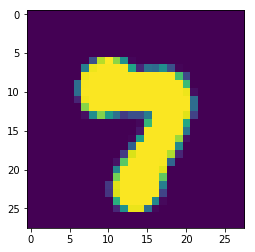

In [231]:
# %% Plot image

iter_train = iter(trainloader)
image, label = next(iter_train)
plt.imshow(image[0,0,:,:])
print(label)
plt.show()
image =image.to(device)
label = label.to(device)

In [0]:
# %% Def training


def train(model, optimizer, criterion, number_of_epochs):
    
    model.train()
    for epoch in range(number_of_epochs):  # loop over the dataset multiple times

        number_of_data = len(trainloader)
        interval = number_of_data // 10
        running_loss = 0.0
        number_of_correct_labels = 0
        number_of_labels = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = [x.to(device) for x in data]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            predicted_labels = outputs.argmax(1)
            number_of_correct_labels += torch.sum(predicted_labels - labels == 0).item()
            number_of_labels += labels.size(0)
            if i % interval == interval-1:  
                print(f'Train: [{epoch + 1}, {i + 1}/{number_of_data}] loss: {running_loss / number_of_data}, '
                      f'Acc: {round(100*number_of_correct_labels/number_of_labels,2)} %')
                running_loss = 0.0

    print('Finished Training')

# %%

def test(model):

    running_loss = 0.0
    number_of_correct_labels = 0
    number_of_labels = 0
    for i, data in enumerate(testloader, 0):

        inputs, labels = [x.to(device) for x in data]
        outputs = model(inputs)
        predicted_labels = outputs.argmax(1)
        number_of_correct_labels += torch.sum(predicted_labels - labels == 0).item()
        number_of_labels += labels.size(0)
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f' Test: {i + 1} loss: {running_loss / 2000}, '
                  f'Acc: {round(100*number_of_correct_labels / number_of_labels, 2)} %')
            running_loss = 0.0
    print(f'Test accuracy: {round(100*number_of_correct_labels / number_of_labels, 2)} %')



## Models

# %% Define modules




In [0]:
def init_weights(channel_out,channel_input,width,height):
    k = 1./ (channel_input * width * height)
    return (torch.rand(channel_out,channel_input,width,height)-0.5) * torch.sqrt(torch.Tensor([k]))
    
    

In [0]:
class DeterministClassifier(nn.Module):

    def __init__(self, number_of_classes):
        super(DeterministClassifier,self).__init__()
        self.conv1 = nn.Conv2d(1,16,3,padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.pool2 = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(32*7*7, number_of_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1,32*7*7)
        output = F.softmax(self.fc1(x))

        return output

class ProbabilistClassifier(nn.Module):
    
    def __init__(self, number_of_classes):
        super(ProbabilistClassifier,self).__init__()
        
        self.mu1 = nn.Parameter(data=init_weights(16,1,3,3),requires_grad=True)
        self.pool1 = nn.MaxPool2d(2,2)
        self.mu2 = nn.Parameter(data=init_weights(32,16,3,3),requires_grad=True)
        self.pool2 = nn.MaxPool2d(2,2)
        
        #self.mufc = nn.Parameter(data=torch.rand(10,16*14*14),requires_grad=True)
        self.fc1 = nn.Linear(32*7*7, number_of_classes)

    def forward(self, x):
        weights = 
        x = self.pool1(F.relu(F.conv2d(x,self.mu1 + self.sigma*random(),padding=1)))
        x = self.pool2(F.relu(F.conv2d(x,self.mu2,padding=1)))
        x = x.view(-1,32*7*7)
        output = F.softmax(self.fc1(x))
        #output = F.softmax(F.linear(x, self.mufc))
        return output
    
class ProbabilistClassifier2(nn.Module):
    
    def __init__(self, number_of_classes):
        super(ProbabilistClassifier2,self).__init__()
        self.mu1 = nn.Parameter(data=torch.rand(16,1,3,3),requires_grad=True)
        self.pool1 = nn.MaxPool2d(2,2)
        self.mu2 = nn.Parameter(data=torch.rand(32,16,3,3),requires_grad=True)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.mufc = nn.Parameter(data=torch.rand(10,32*7*7),requires_grad=True)
       # self.fc1 = nn.Linear(32*7*7, number_of_classes)

    def forward(self, x):
        conv1 = nn.Conv2d(1,16,3,padding=1).to(device)
        conv1.weight.data = self.mu1
        conv2 = nn.Conv2d(16,32,3,padding=1).to(device)
        conv2.weight.data = self.mu2
        
        x = self.pool1(F.relu(conv1(x)))
        x = self.pool2(F.relu(conv2(x)))
        x = x.view(-1,32*7*7)
        #output = F.softmax(self.fc1(x))
        output = F.softmax(F.linear(x, self.mufc))
        return output
    
class DenseProbabilistClassifier(nn.Module):
    
    def __init__(self, number_of_classes):
        super(DenseProbabilistClassifier,self).__init__()
        self.conv1 = nn.Conv2d(1,16,3,padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.pool2 = nn.MaxPool2d(2,2)

        #self.fc1 = nn.Linear(32*7*7, number_of_classes)
        self.mu1 = nn.Parameter(data=torch.rand(10,32*7*7),requires_grad=True)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1,32*7*7)
        #output = F.softmax(self.fc1(x))
        weights = self.mu1
        output = F.softmax(F.linear(x,weights))
        return output

In [0]:
model_proba = ProbabilistClassifier(10)
model_proba.to(device)
adam_proba = optim.Adam(model_proba.parameters())
criterion = nn.CrossEntropyLoss()

In [0]:
model_proba.mu1

In [323]:
train(model_proba,adam_proba,criterion,1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train: [1, 375/3750] loss: 0.175157230981191, Acc: 72.15 %
Train: [1, 750/3750] loss: 0.16267022879918416, Acc: 77.97 %
Train: [1, 1125/3750] loss: 0.15572323481241862, Acc: 82.24 %
Train: [1, 1500/3750] loss: 0.15196398865381877, Acc: 85.29 %
Train: [1, 1875/3750] loss: 0.15152535219192506, Acc: 87.2 %
Train: [1, 2250/3750] loss: 0.1513173193613688, Acc: 88.51 %
Train: [1, 2625/3750] loss: 0.15105015672047933, Acc: 89.47 %
Train: [1, 3000/3750] loss: 0.1503132563908895, Acc: 90.27 %
Train: [1, 3375/3750] loss: 0.149904935614268, Acc: 90.95 %
Train: [1, 3750/3750] loss: 0.1500174873352051, Acc: 91.47 %
Finished Training


In [294]:
model_proba.zero_grad()
output = model_proba(image)
loss = criterion(output,label)
loss.backward()
[(name, torch.abs(k.grad).sum()) if k.grad is not None else (name,k.grad) for (name, k) in model_proba.named_parameters()]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[('mu1', tensor(0.5091, device='cuda:0')),
 ('mu2', tensor(2.7432, device='cuda:0')),
 ('fc1.weight', tensor(180.2423, device='cuda:0')),
 ('fc1.bias', tensor(0.0334, device='cuda:0'))]

In [291]:
model = DeterministClassifier(10)
model.conv1.weight.data

tensor([[[[-0.3315,  0.3295, -0.0089],
          [ 0.1450, -0.3100, -0.1409],
          [ 0.0284, -0.3216,  0.0384]]],


        [[[ 0.0680,  0.1758,  0.2656],
          [ 0.0437,  0.0955, -0.1784],
          [-0.2123, -0.3266,  0.0280]]],


        [[[-0.2569, -0.2571, -0.2754],
          [-0.2883, -0.0703,  0.1990],
          [ 0.2720,  0.0206,  0.0062]]],


        [[[-0.1546, -0.2378,  0.1914],
          [ 0.2666,  0.3301, -0.0437],
          [ 0.2658,  0.3119, -0.1413]]],


        [[[-0.0411, -0.2840,  0.2892],
          [ 0.1991,  0.1910,  0.1826],
          [ 0.1032,  0.3029,  0.0534]]],


        [[[-0.0357,  0.0159,  0.0182],
          [ 0.2724, -0.0514, -0.1378],
          [-0.2161,  0.0393, -0.0480]]],


        [[[ 0.0095,  0.1137,  0.2032],
          [ 0.1709, -0.2291,  0.0639],
          [-0.3150,  0.0808,  0.2071]]],


        [[[-0.2287,  0.2490, -0.0311],
          [ 0.1692, -0.0311,  0.2424],
          [-0.0575, -0.2360, -0.1771]]],


        [[[-0.1679, -0.0989,  0.

In [279]:
[(name, torch.abs(k.grad).sum()) if k.grad is not None else (name,k.grad) for (name, k) in model_proba.named_parameters()]

[('mu1', tensor(0., device='cuda:0')),
 ('mu2', tensor(0., device='cuda:0')),
 ('fc1.weight', tensor(0., device='cuda:0')),
 ('fc1.bias', tensor(0., device='cuda:0'))]

In [0]:
[(name, k.grad) if k is not None else (name,k) for (name, k) in model_dense_proba.named_parameters()]

In [0]:
model_dense_proba = DenseProbabilistClassifier(nn.Module)
model_dense_proba.to(device)
adam_proba_dense = optim.Adam(model_dense_proba.parameters())
criterion = nn.CrossEntropyLoss()

In [0]:
train(model_dense_proba,adam_proba_dense,criterion,1)

In [155]:
[torch.abs(k.grad).sum() for k in list(model.fc1.parameters())]

[tensor(7.8311, device='cuda:0'), tensor(0.0102, device='cuda:0')]

In [0]:
# %% Definition of model

model = DeterministClassifier(number_of_classes=10)
model.to(device)
sgd = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
adam = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [0]:
# %% Training
number_of_epochs = 3
train(model, adam, criterion, number_of_epochs)

# %% Testing
mu1 = nn.Parameter(data=torch.Tensor(16, 1, (3, 3)), requires_grad=True)
bias1 = nn.Parameter(data=torch.Tensor(16), requires_grad=True)
output1 = F.conv2d(image, weight=mu1, bias=bias1, padding=1)
